In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import seaborn as sns

In [2]:
states=["vic","nsw","sa","tas"]

df_all = pd.DataFrame()
for state in tqdm.tqdm(states):
    df = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/points/barpac_m_aws_"+state+".csv").\
        dropna(subset="gust").\
        drop(columns=["time"]).\
        rename(columns={"Unnamed: 1":"time"})
    df = df.set_index(pd.to_datetime(df["time"]))
    df["state"] = state
    df_all = pd.concat([df_all,
                        df[["stn_id","dt_floor_6H", 'state',
                            'mu_cape', 'mu_cin', 's06', 'wg10', 'bdsd', 'qmean01','Umean06', 'lr13', 'mucape*s06', 'cluster', 'dcape',
                            's06_era5', 'qmean01_era5','Umean06_era5', 'lr13_era5', 'bdsd_era5', 'dcape_era5', 'mu_cape_era5', 'cluster_era5',
                            'n_lightning_fl', 'Lightning_observed_daily']].\
                        drop_duplicates(["stn_id","dt_floor_6H"])],
                        axis=0)

100%|██████████| 4/4 [13:33<00:00, 203.36s/it]


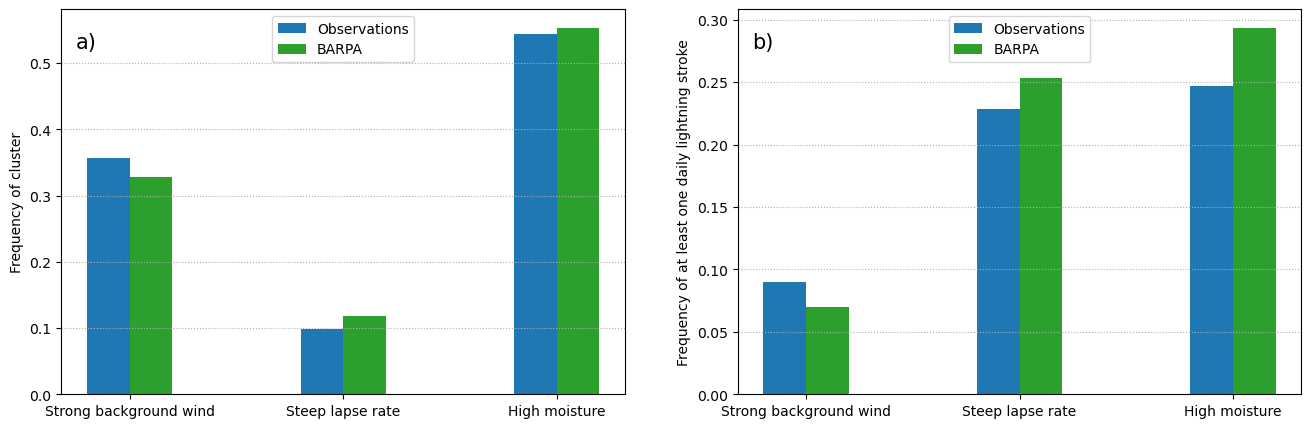

In [3]:
obs_freq = []
barpa_freq = []
clusters = np.array([1,2,0])
for c in clusters:
    obs_freq.append(df_all[(df_all["cluster_era5"]==c)].shape[0] / df_all.shape[0])
    barpa_freq.append(df_all[(df_all["cluster"]==c)].shape[0] / df_all.shape[0])    

obs_lightning_freq = []
barpa_lightning_freq = []
clusters = np.array([1,2,0])
for c in clusters:
    obs_lightning_freq.append(df_all[(df_all["cluster_era5"]==c) & (df_all["Lightning_observed_daily"]>=1)].shape[0] / df_all[(df_all["cluster_era5"]==c)].shape[0])
    barpa_lightning_freq.append(df_all[(df_all["cluster"]==c) & (df_all["n_lightning_fl"]>=1)].shape[0] / df_all[(df_all["cluster"]==c)].shape[0])    
    
plt.figure(figsize=[16,5])
plt.subplot(1,2,1)
plt.bar(np.array([0,1,2])-0.1, obs_freq,width=0.2,color="tab:blue",label="Observations")
plt.bar(np.array([0,1,2])+0.1, barpa_freq,color="tab:green",width=0.2,label="BARPA")
plt.legend(loc=9)
plt.xticks([0,1,2],["Strong background wind","Steep lapse rate","High moisture"])
plt.ylabel("Frequency of cluster")
plt.gca().grid(ls=":",axis="y")
plt.text(0.025,0.9,"a)",size=15,transform=plt.gca().transAxes)

plt.subplot(1,2,2)
plt.bar(np.array([0,1,2])-0.1, obs_lightning_freq,width=0.2,color="tab:blue",label="Observations")
plt.bar(np.array([0,1,2])+0.1, barpa_lightning_freq,color="tab:green",width=0.2,label="BARPA")
plt.legend(loc=9)
plt.xticks([0,1,2],["Strong background wind","Steep lapse rate","High moisture"])
plt.ylabel("Frequency of at least one daily lightning stroke")
plt.gca().grid(ls=":",axis="y")
plt.text(0.025,0.9,"b)",size=15,transform=plt.gca().transAxes)

plt.savefig("/g/data/eg3/ab4502/figs/barpa/cluster_and_lightning_frequency_comparison.jpeg",dpi=300,bbox_inches="tight")

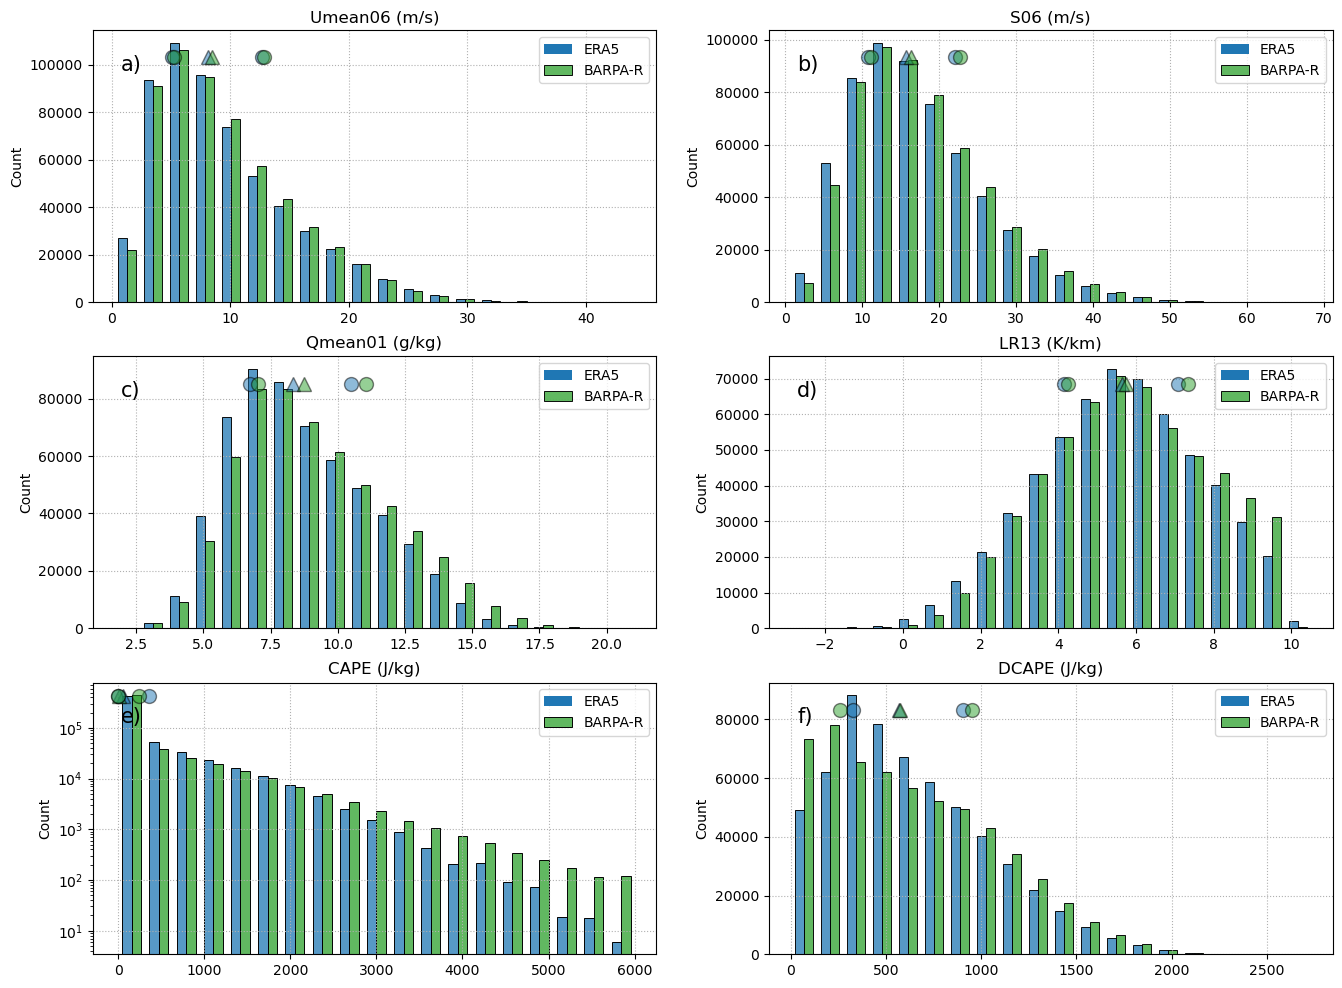

In [5]:
import matplotlib.patheffects as pe

def plot_hist(ax,v,letter,bins=20,multiple="dodge",shrink=0.7,log=False):

    colors=["tab:blue","tab:green"]    
    sns.histplot(df_all[[v+"_era5",v]],bins=bins,multiple=multiple,shrink=shrink,ax=ax,palette=colors)
    plt.legend(["ERA5","BARPA-R"])
    ax.grid(ls=":")
    #[ax.axvline(i,color=c,ls="-",lw=2, path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()]) for i,c in zip(df_all[[v+"_era5",v]].median(),colors)]
    [ax.plot(i,ax.get_ylim()[1] * 0.9, color=c,ls="none",marker="^",mec="k",ms=10,alpha=0.5) for i,c in zip(df_all[[v+"_era5",v]].median(),colors)]
    [ax.plot(i,ax.get_ylim()[1] * 0.9, color=c,ls="none",marker="o",mec="k",ms=10,alpha=0.5) for i,c in zip(df_all[[v+"_era5",v]].quantile(0.75),colors)]
    [ax.plot(i,ax.get_ylim()[1] * 0.9, color=c,ls="none",marker="o",mec="k",ms=10,alpha=0.5) for i,c in zip(df_all[[v+"_era5",v]].quantile(0.25),colors)]
    if log:
        plt.yscale("log")
    titles = {"Umean06":"Umean06 (m/s)","s06":"S06 (m/s)","qmean01":"Qmean01 (g/kg)","lr13":"LR13 (K/km)","mu_cape":"CAPE (J/kg)","dcape":"DCAPE (J/kg)"}
    plt.title(titles[v])
    plt.text(0.05,0.85,letter,size=15,transform=plt.gca().transAxes)
        
plt.figure(figsize=[16,12])
plot_hist(plt.subplot(3,2,1),"Umean06","a)")
plot_hist(plt.subplot(3,2,2),"s06","b)")
plot_hist(plt.subplot(3,2,3),"qmean01","c)")
plot_hist(plt.subplot(3,2,4),"lr13","d)")
plot_hist(plt.subplot(3,2,5),"mu_cape","e)",bins=np.linspace(0,6000,20),log=True)
plot_hist(plt.subplot(3,2,6),"dcape","f)")

plt.savefig("/g/data/eg3/ab4502/figs/barpa/environment_comparison.jpeg",dpi=300,bbox_inches="tight")

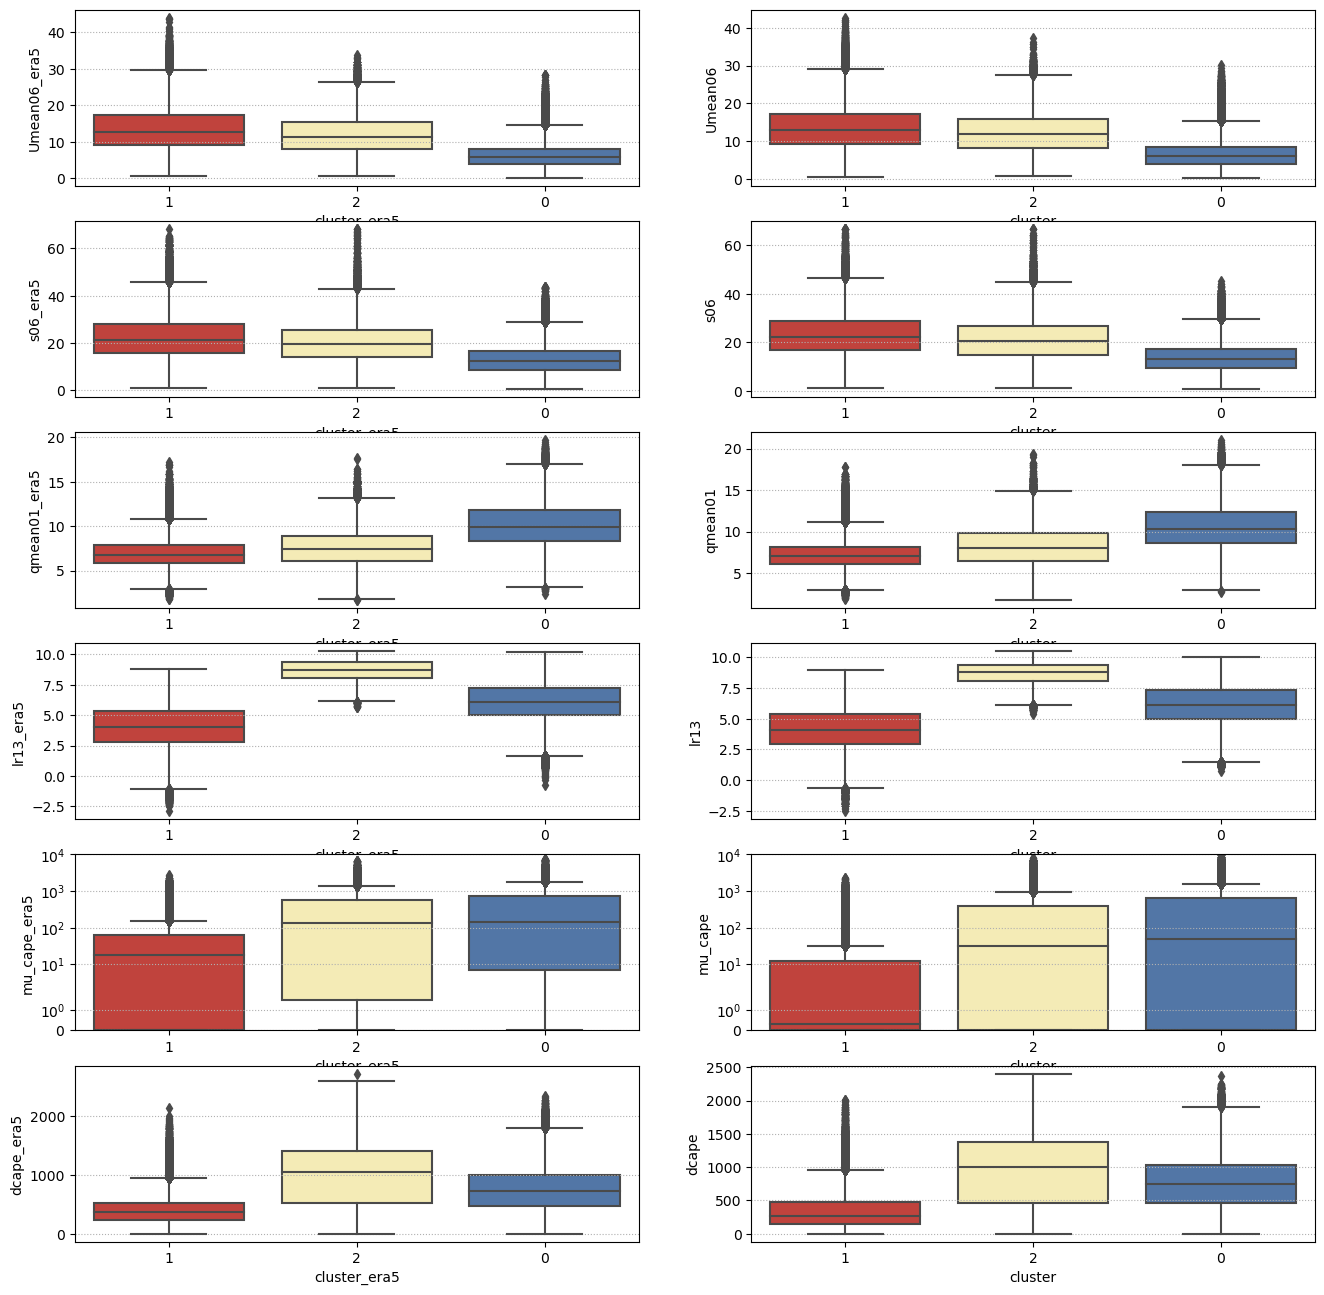

In [140]:
def plot_box(v,x,ax):
    sns.boxplot(data=df_all,y=v,x=x,order=[1,2,0],ax=ax,palette=[plt.get_cmap("RdYlBu")(i) for i in [0.1,0.46,0.9]])
    plt.gca().grid(axis="y",ls=":")
    
plt.figure(figsize=[16,16])
plot_box("Umean06_era5","cluster_era5",plt.subplot(6,2,1))
plot_box("Umean06","cluster",plt.subplot(6,2,2))

plot_box("s06_era5","cluster_era5",plt.subplot(6,2,3))
plot_box("s06","cluster",plt.subplot(6,2,4))

plot_box("qmean01_era5","cluster_era5",plt.subplot(6,2,5))
plot_box("qmean01","cluster",plt.subplot(6,2,6))

plot_box("lr13_era5","cluster_era5",plt.subplot(6,2,7))
plot_box("lr13","cluster",plt.subplot(6,2,8))

plot_box("mu_cape_era5","cluster_era5",plt.subplot(6,2,9)); plt.yscale("symlog"); plt.ylim([0,1e4])
plot_box("mu_cape","cluster",plt.subplot(6,2,10)); plt.yscale("symlog"); plt.ylim([0,1e4])

plot_box("dcape_era5","cluster_era5",plt.subplot(6,2,11))
plot_box("dcape","cluster",plt.subplot(6,2,12))